## Experiments with _Water meters_!
In this notebook we will train ResNet101, DenseNet121 and VGG19 to predict numbers on water meter.

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline
from water_batch import WaterBatch
sys.path.append('..')
import dataset
import utils
from dataset import B,V,F, FilesIndex, Dataset, Pipeline
from dataset.dataset.models.tf import ResNet101, DenseNet121, VGG19

In [2]:
def concatenate_water(batch, model, return_targets=True):
    _ = model
    try:
        x = np.concatenate(np.concatenate(batch.sepcrop))
    except:
        print(batch.sepcrop.shape, batch.sepcrop[0].shape, batch.sepcrop[0][0].shape)
    x = x.reshape(-1, 64, 32, 3)
    y = np.concatenate(batch.labels).reshape(-1)
    res_dict = {"feed_dict": {"images": x, "labels": y}}
    return res_dict


In [3]:
src = './data/images/'

fileindex = FilesIndex(path=src+'*.blosc', no_ext=True)

dset = Dataset(fileindex, batch_class=WaterBatch)
dset.cv_split()

In [4]:
b = (Pipeline()
        .load(src=src, fmt='blosc', components='images')
        .load(src='./data/labels/meters.csv', \
              fmt='csv',\
              components='labels',\
              usecols=['file_name', 'counter_value'], crop_labels=True)
        .load(src='./data/labels/answers.csv', \
              fmt='csv', \
              components='coordinates',\
              usecols=['markup'])
        .normalize_images()
        .crop_to_bbox()
       .crop_to_numbers())

In [5]:
inputs_config = {
    'images': {'shape':(64, 32, 3)},
    'labels':{'classes':(10), 'transform':'ohe', 'name':'targets'}
}

config = {
    'inputs':inputs_config,
    'optimizer': 'Adam',
    'loss': 'ce',
    'input_block/inputs': 'images',
    'head/units': 10,
    'output': dict(ops=['labels', 'proba', 'accuracy'])}

In [6]:
models = [DenseNet121, VGG19, ResNet101]
models_names = ['DenseNet121', 'VGG19', 'ResNet101']
models_dict = dict(zip(models_names, models))

In [7]:
def get_ppl(model, name):
    train_ppl = ((b<<dset.train)
                 .init_variable('model', model)
                 .init_variable('loss', init_on_each_run=list)
                 .init_model('dynamic',
                            V('model'),
                            name,
                            config=config)
                 .train_model(name,
                             fetches='loss',
                             make_data=concatenate_water,
                             save_to=V('loss'), mode='a'))

    test_ppl = ((b<<dset.test)
                 .init_variable('proba', init_on_each_run=list)
                 .init_variable('target', init_on_each_run=list)
                 .init_variable('accuracy', init_on_each_run=list)
                 .import_model(name, train_ppl)
                 .predict_model(name,
                                fetches=['output_proba',
                                         'targets', 'output_accuracy'],
                                make_data=concatenate_water,
                                save_to=[V('proba'), V('target'), V('accuracy')], mode='a'))
    return train_ppl, test_ppl

ResNet101


/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


../utils.py:45: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)


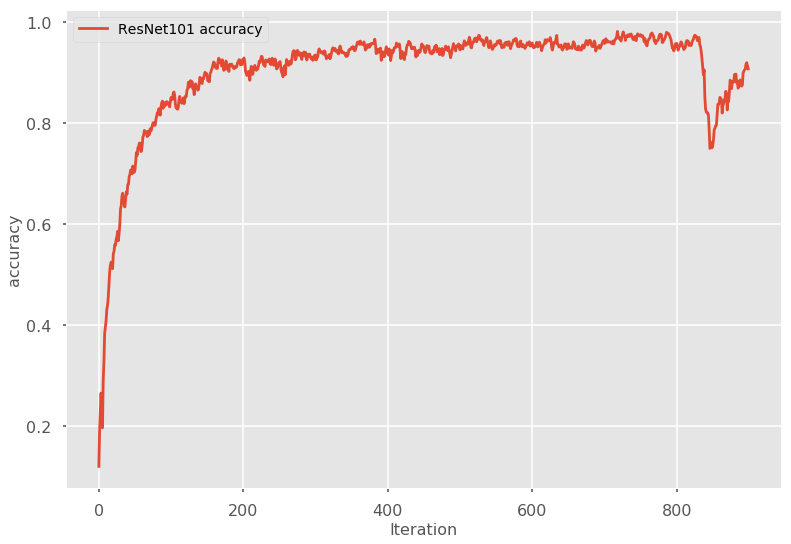

DenseNet121


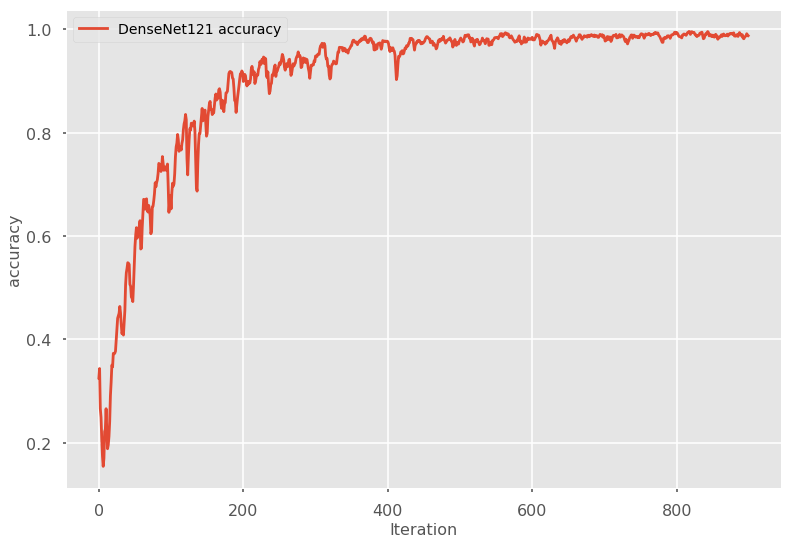

VGG19


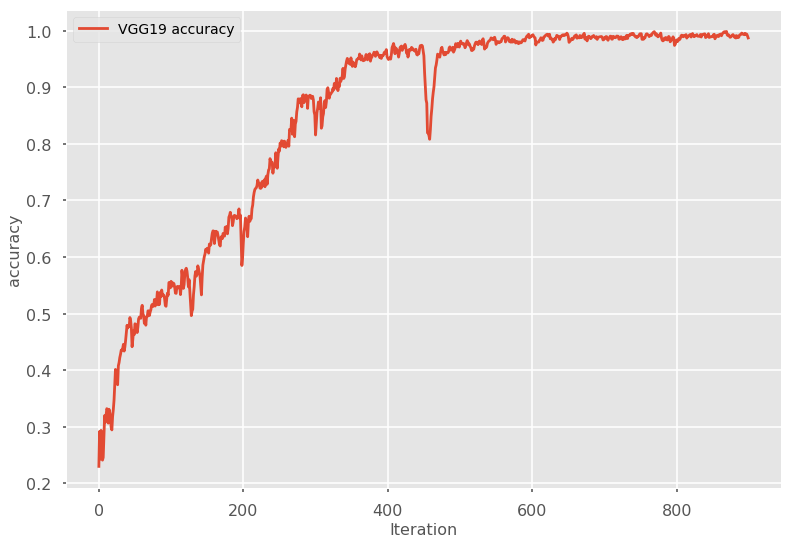

In [8]:
global_acc = []
for name, model in models_dict.items():
    print(name)
    train_ppl, test_ppl = get_ppl(model, name)
    for i in tqn(range(900)):
        tr = train_ppl.next_batch(25, n_epochs=None, suffle=True, drop_last=True)
        te = test_ppl.next_batch(25, n_epochs=None, suffle=True, drop_last=True)
    utils.draw(test_ppl.get_variable('accuracy'), name, type_data='accuracy')
    plt.show()
    global_acc.append(test_ppl.get_variable('accuracy'))
    train_ppl.save_model(name, path=name)

In [8]:
config = {
    'inputs':inputs_config,
    'optimizer': 'Adam',
    'loss': 'ce',
    'load':{'path':'./DenseNet121/'},
    'input_block/inputs': 'images',
    'head/units': 10,
    'output': dict(ops=['labels', 'proba', 'accuracy'])}

In [9]:
%%time
model = DenseNet121(config=config)

INFO:tensorflow:Restoring parameters from ./DenseNet121/model-1383
CPU times: user 5min 31s, sys: 8.58 s, total: 5min 39s
Wall time: 5min 38s


In [10]:
predict_ppl = ((b<<dset.test)
               .init_variable('prediction', init_on_each_run=list)
               .init_variable('proba', init_on_each_run=list)
               .init_variable('accuracy', init_on_each_run=list)
               .import_model('DenseNet121', model)
               .predict_model('DenseNet121',
                              fetches=['output_labels',
                                       'output_proba', 'output_accuracy'],
                              make_data=concatenate_water,
                              save_to=[V('prediction'), V('proba'), V('accuracy')], mode='a'))

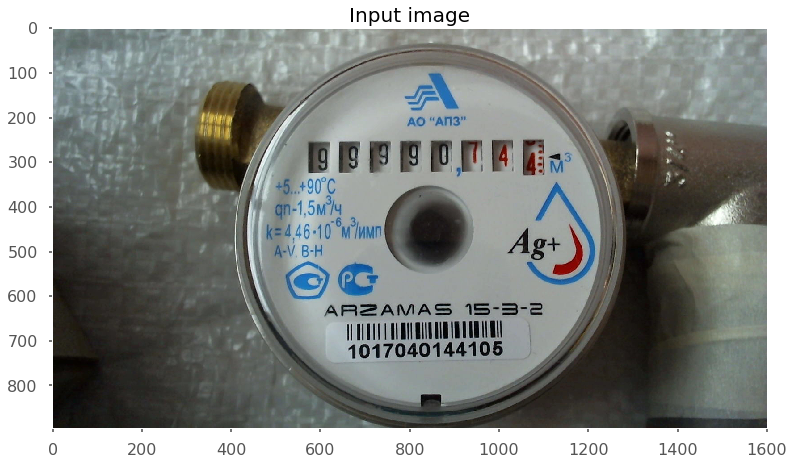

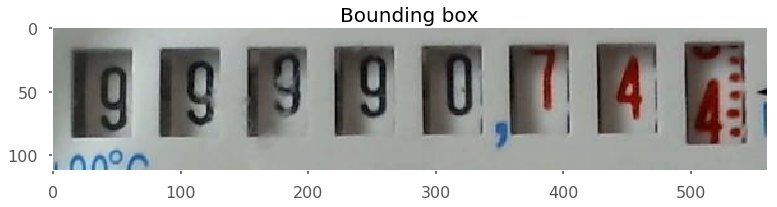

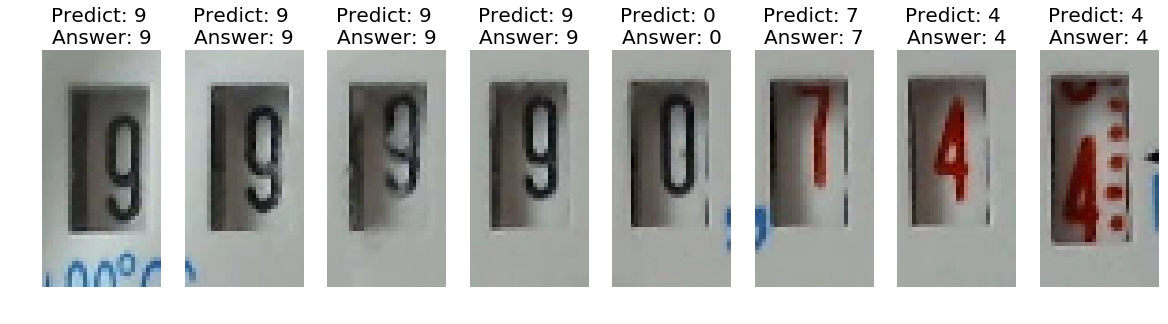

In [12]:
batch_test = predict_ppl.next_batch(1, n_epochs=None, shuffle=True)

predict = predict_ppl.get_variable('prediction')[-1]
labels = batch_test.labels[-1]
sepcrop = batch_test.sepcrop[-1]
plt.title('Input image', fontsize=20)
plt.imshow(batch_test.images[-1])
plt.grid()
plt.show()

plt.title('Bounding box', fontsize=20)
plt.imshow(batch_test.cropped[-1])
plt.grid()

_, axis = plt.subplots(1, 8, figsize=(20, 10))
axis = axis.reshape(-1)
for i in range(8):
    axis[i].imshow(sepcrop[i])
    axis[i].set_title('Predict: {} \nAnswer: {}'.format(predict[i], labels[i]), fontsize=20)
    axis[i].grid()
    axis[i].axis('off')
plt.show()

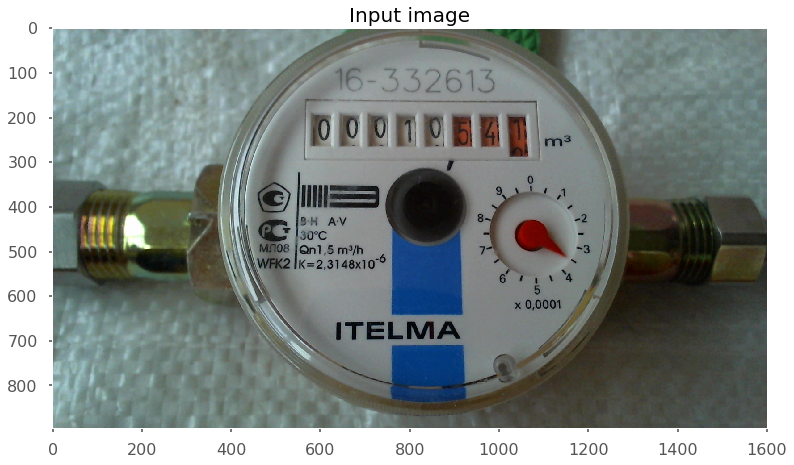

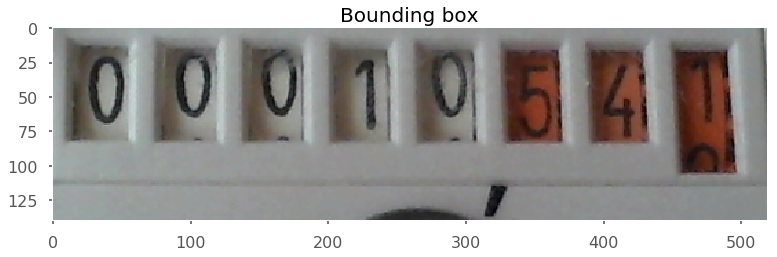

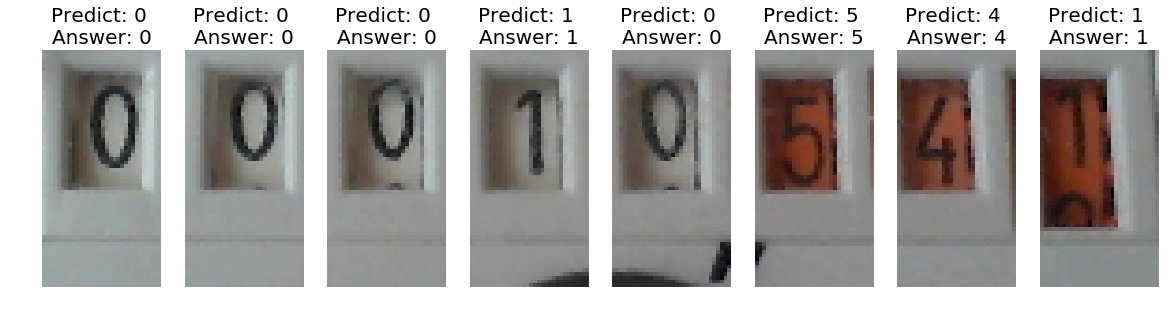

In [16]:
batch_test = predict_ppl.next_batch(1, n_epochs=None, shuffle=True)

predict = predict_ppl.get_variable('prediction')[-1]
labels = batch_test.labels[-1]
sepcrop = batch_test.sepcrop[-1]
plt.title('Input image', fontsize=20)
plt.imshow(batch_test.images[-1])
plt.grid()
plt.show()

plt.title('Bounding box', fontsize=20)
plt.imshow(batch_test.cropped[-1])
plt.grid()

_, axis = plt.subplots(1, 8, figsize=(20, 10))
axis = axis.reshape(-1)
for i in range(8):
    axis[i].imshow(sepcrop[i])
    axis[i].set_title('Predict: {} \nAnswer: {}'.format(predict[i], labels[i]), fontsize=20)
    axis[i].grid()
    axis[i].axis('off')
plt.show()